# Training a Teleportation Protocol

In this notebook we demo how `qnetvo` can be used to train LOCC protocols such as teleportation.
For details about the quantum teleportation protocol please review the [Wikipedia article on quantum teleportation](https://en.wikipedia.org/wiki/Quantum_teleportation).

In [1]:
import pennylane as qml
import numpy as np
from pennylane import numpy as qnp
from scipy.stats import unitary_group
from matplotlib import pyplot as plt

import qnetvo

## State Preparation

We begin by defining the preparation nodes.
Teleportation requires entanglement between the two parties, so we consider a general two-qubit state preparation.

In [2]:
entanglement_prep_node = qnetvo.PrepareNode(
    wires=[1,2], ansatz_fn=qml.ArbitraryStatePreparation, num_settings=6
)

Since the input to the telelportation protocol is a quantum state, we create a generator function to create the input qubit state from a vector.
That is, the following function returns the prepare node that initializes the specified state.

In [3]:
def input_prep_node(state_vec):
    def circuit(settings, wires):
        qml.QubitStateVector(state_vec, wires=wires[0])

    return qnetvo.PrepareNode(wires=[0], ansatz_fn=circuit)

## Classical Communication

In quantum teleportation a Bell state measurement must be applied to the input state and one qubit of the entangled pair.
The result is then communicated to the receiving party who can apply conditional operations to recover the input state.

We use an arbitrary two-qubit measurement whose two-bit measurement is output as classical communication.

In [4]:
def cc_sender_circ(settings, wires):
    qml.ArbitraryUnitary(settings, wires=wires[0:2])

    b0 = qml.measure(wires[0])
    b1 = qml.measure(wires[1])

    return [b0, b1]

cc_sender_node = qnetvo.CCSenderNode(wires=[0,1], cc_wires_out=[0,1], ansatz_fn=cc_sender_circ, num_settings=15)

The classical communication is received and used to condition a decoding operation.
As an ansatz we consider a general qubit unitary for these conditional operations.

In [5]:
def cc_receiver_circ(settings, wires, cc_wires):
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 1), qml.Rot)(*settings[0:3], wires=wires[0])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 0), qml.Rot)(*settings[3:6], wires=wires[0])
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 1), qml.Rot)(*settings[6:9], wires=wires[0])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 1), qml.Rot)(*settings[9:12], wires=wires[0])


cc_receiver_node = qnetvo.CCReceiverNode(wires=[2], cc_wires_in=[0,1], ansatz_fn=cc_receiver_circ, num_settings=12)

## Quantifying Teleportation Success

To train a teleportation protocol, we need a metric of success.
Thus, we use the fidelity to measure the distance between the input state and the output from the teleportation protocol.
Furthermore, a cost function should consider the average fidelity across many states to accurately determine the fidelity of the teleportation channel.

We now write a generator for cost functions that will calculate the average teleportation fidelity, evaluated for a collection of input qubit state vectors.

In [6]:
def cost_fn(input_states):
    input_prep_nodes = [input_prep_node(state) for state in input_states]
    ansatzes = [
        qnetvo.NetworkAnsatz(
            [input_prep_node, entanglement_prep_node], [cc_sender_node], [cc_receiver_node]
        )
        for input_prep_node in input_prep_nodes
    ]

    # construct a qnode that outputs a density matrix
    def teleport_qnode_fn(ansatz):
        @qml.qnode(qml.device(**ansatz.dev_kwargs))
        def teleport(settings):
            ansatz.fn(settings)
            return qml.density_matrix(2)

        return teleport

    teleport_circuits = [teleport_qnode_fn(ansatz) for ansatz in ansatzes]

    # minimize average teleportation fidelity
    def cost(*settings):
        cost_val = 0
        for i in range(len(teleport_circuits)):
            teleport_circuit = teleport_circuits[i]
            input_state = input_states[i]

            rho = teleport_circuit(settings)
            rho_target = np.outer(input_state, input_state.conj())

            cost_val -= qml.math.fidelity(rho, rho_target)

        return cost_val / len(teleport_circuits)

    return cost

## Training a Teleportation Protocol

We first select a collection of training states to use while training the protocol.
We find that a handful of basis states are sufficient for good results.

In [7]:

training_states = [
    np.array([1, 0]),
    np.array([1, 1]) / np.sqrt(2),
    np.array([1, -1]) / np.sqrt(2),
    np.array([1, 1j]) / np.sqrt(2),
]

training_cost = cost_fn(training_states)

init_settings = qnetvo.NetworkAnsatz(
    [input_prep_node(training_states[0]), entanglement_prep_node],
    [cc_sender_node],
    [cc_receiver_node],
).rand_network_settings()

# optimizing teleportation protocol
opt_dict = qnetvo.gradient_descent(
    training_cost,
    init_settings,
    step_size=1.5,
    num_steps=100,
    sample_width=5,
    verbose=True,
)

iteration :  0 , score :  0.504359420951347
elapsed time :  0.17290496826171875


/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  return A.astype(dtype, order, casting, subok, copy)


iteration :  5 , score :  0.7436241482838359
elapsed time :  0.1572427749633789
iteration :  10 , score :  0.8540371836660141
elapsed time :  0.15592193603515625
iteration :  15 , score :  0.9105520254857109
elapsed time :  0.17200922966003418
iteration :  20 , score :  0.9457806088779747
elapsed time :  0.26865077018737793
iteration :  25 , score :  0.9680478812309269
elapsed time :  0.22971081733703613
iteration :  30 , score :  0.9805726216754486
elapsed time :  0.26746225357055664
iteration :  35 , score :  0.9872443468987838
elapsed time :  0.14332914352416992
iteration :  40 , score :  0.9910436284670598
elapsed time :  0.14395499229431152
iteration :  45 , score :  0.9934400772207939
elapsed time :  0.14708495140075684
iteration :  50 , score :  0.9950574232438493
elapsed time :  0.17879819869995117
iteration :  55 , score :  0.9961905295308935
elapsed time :  0.19864606857299805
iteration :  60 , score :  0.9970046804162166
elapsed time :  0.2020580768585205
iteration :  65 , s

## Testing Trained Teleportation Protocol

We test the trained protocol to see how well it performs.
To do this, we randomly select 100 qubit states and construct a new cost function for testing the trained protocol.
We then apply our optimal settings into the test cost function to find the test score.

In [8]:
# generating new random states to test teleportation protocol
test_states = [unitary_group.rvs(2)[:, 0] for i in range(100)]
test_cost = cost_fn(test_states)

# np.isclose(test_cost(*opt_dict["opt_settings"]), -1, atol=5e-3)
test_score = - test_cost(*opt_dict["opt_settings"])

print("test score : ", test_score)

test score :  0.9986159961740175


Finally, we plot the gradient descent optimization and the test score to show how they compare.
Since the fidelity is maximal at value one, we use (1 - Average Fidelity) to measure closeness on a logscale

Text(0.5, 0, 'Gradient Descent Iteration')

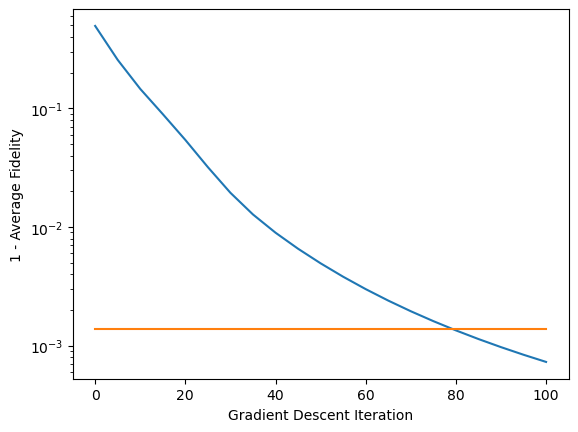

In [9]:
plt.semilogy(range(0,101,5), 1 - np.array(opt_dict["scores"]))
plt.semilogy(range(0,101,5), 1 - np.array([test_score]*21))
plt.ylabel("1 - Average Fidelity")
plt.xlabel("Gradient Descent Iteration")
